In [1]:
import os
os.chdir(f"{os.environ['HOME']}/Postdoc/scRNA/scrna-pipeline/")

import scanpy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
import warnings

from gprofiler import GProfiler

from scanpy_pipeline_helpers import (
  build_gene_mapping,
  filter_chloroplastic_and_mitochondrial,
  query_for_go_terms,
  gene_mapping
)

In [2]:
warnings.filterwarnings("ignore")

In [3]:
RANDOM_STATE = 142

In [4]:
import logging
logger = logging.getLogger('console_logger')
logger.setLevel(logging.DEBUG)
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

In [122]:
def pipeline(data=None, folders=["data/WT1", "data/WT2", "data/WT3"]):

    if data is None:        
        replicas = list()
        for i, folder in enumerate(folders):
            rep_adata = scanpy.read_10x_mtx(folder, make_unique=True)
            rep_adata.var_names_make_unique()
            replicas.append(rep_adata)
            replicas[i].obs["replica"] = f"replica_{i+1}"
    
        data = scanpy.concat(replicas);    
        data.obs_names_make_unique()
        del replicas

    MIN_GENES, MIN_CELLS = 3, 200
    scanpy.pp.filter_cells(data, min_genes=MIN_GENES); logger.info(f"{all_data.shape=}")
    scanpy.pp.filter_genes(data, min_cells=MIN_CELLS); logger.info(f"{all_data.shape=}")

    data = filter_chloroplastic_and_mitochondrial(data)

    FLAVOR = "seurat_v3"
    scanpy.pp.highly_variable_genes(data, flavor="seurat_v3", n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5, span=1, batch_key="replica")
    # all_data.var.sort_values("variances_norm", ascending=False)
    
    scanpy.experimental.pp.normalize_pearson_residuals_pca(data, n_comps=50)
    
    logger.info("scale")
    scanpy.pp.normalize_total(data, target_sum=1e4)
    scanpy.pp.log1p(data)
    scanpy.pp.scale(data)
    
    logger.info("neighbors")
    scanpy.pp.neighbors(data, n_neighbors=10, n_pcs=30, random_state=RANDOM_STATE)
    logger.info("clustering")
    scanpy.tl.louvain(data, resolution=0.70)
    
    scanpy.tl.umap(data, random_state=RANDOM_STATE)
        
    scanpy.tl.rank_genes_groups(data, 'louvain', method='wilcoxon')

    return data


def plot_umaps(all_data):
    
    fig, ax = plt.subplots(1,2, figsize=(16, 6))

    scanpy.pl.umap(all_data, color='louvain', palette='tab20', title='UMAP Colored by Clusters', ax=ax[0], show=False)
    ax[0].legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=False, fontsize=6, title="Clusters",title_fontsize=10)
    
    primary_colors = ['blue', 'red', 'yellow']
    scanpy.pl.umap(all_data, color='replica', palette=primary_colors, title='UMAP Colored by replica', ax=ax[1], show=False)
    ax[1].legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=True, fontsize=10, title="Replicas", title_fontsize=10)
    
    plt.tight_layout()
    plt.show()


def build_pca_loading_df(scanpy_data):
    n_pcs = subset_data.varm['PCs'].shape[1]
    genes = scanpy_data.var_names
    pc_names = [f"PC{i}" for i in range(1, n_pcs+1)]
    loadings = scanpy_data.varm['PCs']
    pca_loadings_df = pd.DataFrame(loadings, index=genes, columns=pc_names)
    return pca_loadings_df


def celltype_to_cluster_contingency(data, top_n=50, log2fc_threshold=5):
   
    gene_markers_by_cell_type = get_top_genes_by_cell_type(top_n=top_n)
    gene_markers_by_cluster   = get_top_genes_by_cluster(data, top_n=top_n)
    
    contingency_table = {}
    
    for group1, elements1 in gene_markers_by_cluster.items():
        row = {}
        for group2, elements2 in gene_markers_by_cell_type.items():
            intersection = set(elements1) & set(elements2)
            row[group2] = len(intersection)
        contingency_table[group1] = row
    
    df = pd.DataFrame(contingency_table)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="Blues", fmt="d", cbar_kws={'label': f'Intersection size ({top_n} is perfect match)'})
    
    plt.title('Cell-type-to-cluster contingency table')
    plt.tight_layout()
    plt.show()

In [123]:
all_data = pipeline()

2025-01-05 09:56:16,752 - INFO - all_data.shape=(11186, 15281)
2025-01-05 09:56:17,215 - INFO - all_data.shape=(11186, 15281)
2025-01-05 09:56:19,386 - INFO - scale
2025-01-05 09:56:20,833 - INFO - neighbors
2025-01-05 09:56:21,824 - INFO - clustering


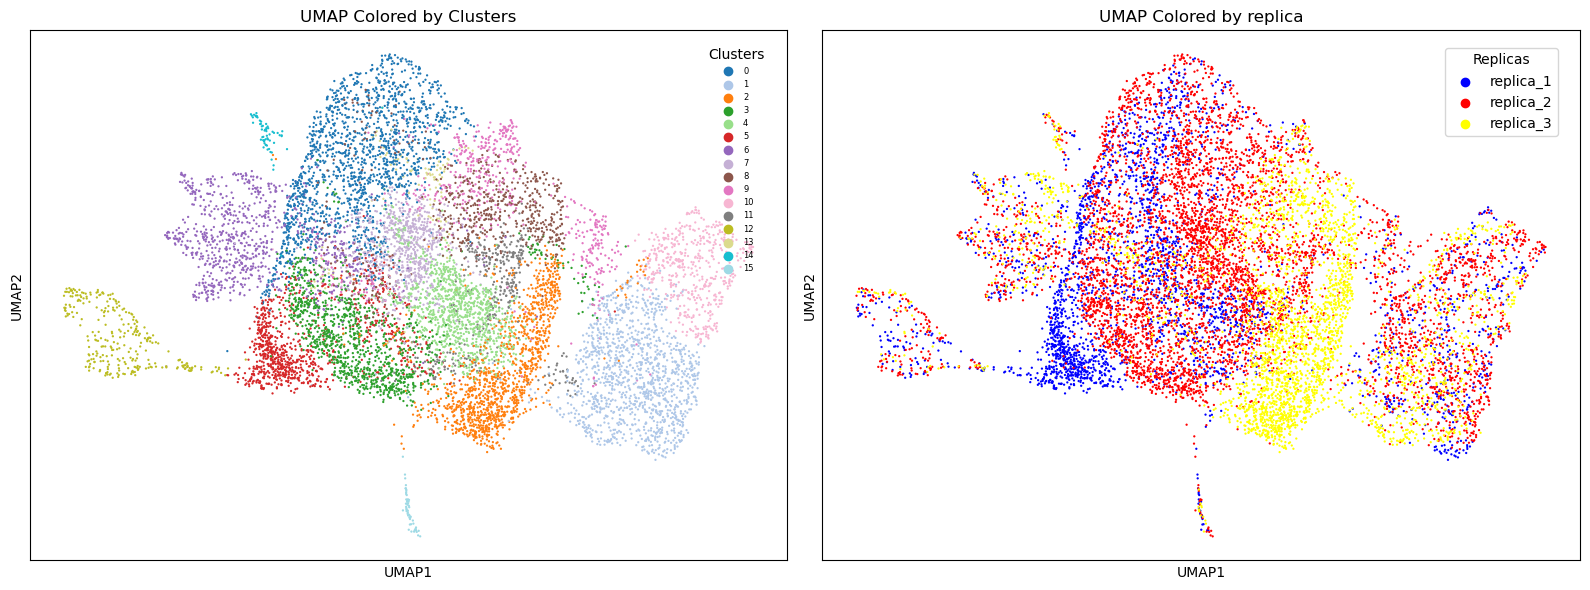

In [124]:
plot_umaps(all_data)

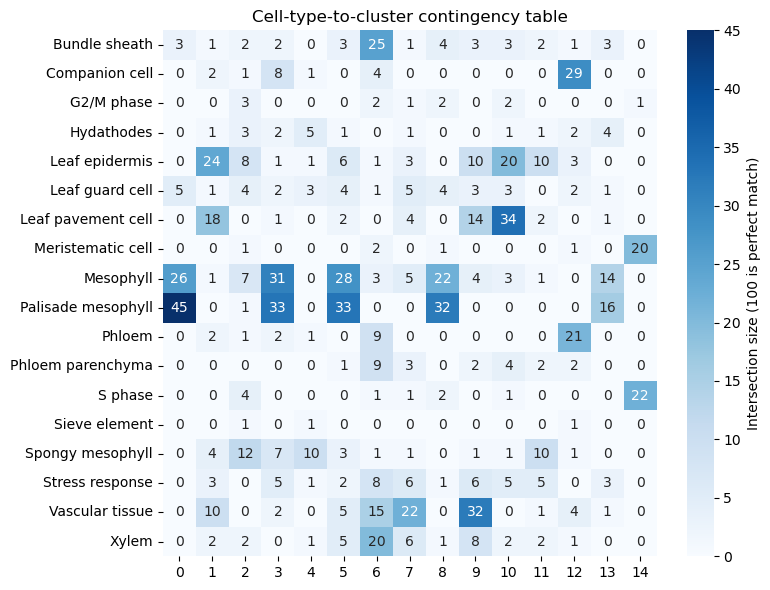

In [125]:
celltype_to_cluster_contingency(all_data, top_n=100)

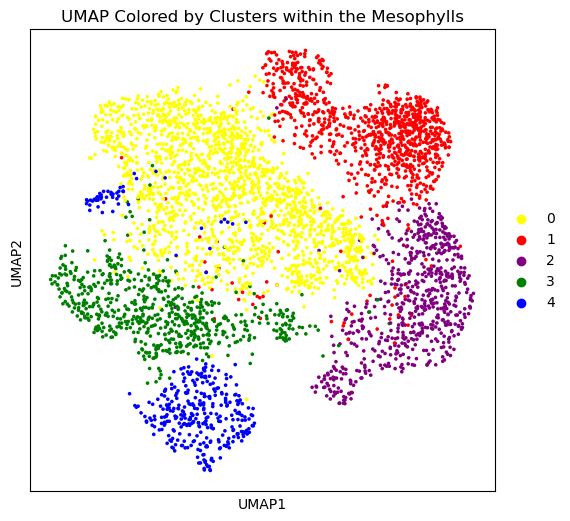

In [117]:
# mesophyll_clusters = ['5', '6', '7', '8']
mesophyll_clusters = ['0', '3', '5', '8', '13']

subset_data = all_data[all_data.obs['louvain'].isin(mesophyll_clusters)].copy()

scanpy.pp.pca(subset_data, n_comps=20)
scanpy.pp.neighbors(subset_data)
scanpy.tl.louvain(subset_data, resolution=0.25)
scanpy.tl.umap(subset_data)

fig, ax = plt.subplots(1,1, figsize=(6, 6))
scanpy.pl.umap(subset_data, color='louvain', palette=['yellow', 'red', 'purple', 'green', 'blue', 'orange', 'brown'], title='UMAP Colored by Clusters within the Mesophylls', ax=ax, show=False);

In [70]:
pc_loadings_df = build_pca_loading_df(subset_data)

In [53]:
go_terms = list()

for pc in range(1, 5):
    top_genes = pca_loadings_df[f"PC{pc}"].abs().sort_values(ascending=False).head(100)
    go_terms_for_pc = query_for_go_terms(top_genes.index).assign(PC=pc).drop(['significant', 'query'], axis=1)
    go_terms.append(go_terms_for_pc)

go_terms = pd.concat(go_terms).reset_index().sort_values("p_value")
idx = go_terms.groupby('native')['p_value'].idxmin()
go_terms.loc[idx].sort_values("p_value").head(20)

,index,source,native,name,p_value,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,parents,PC
83,0,GO:BP,GO:0042221,response to chemical,2.787090e-26,"""Any process that results in a change in state...",2983,81,55,21899,0.679012,0.018438,[GO:0050896],2
281,0,GO:BP,GO:0006950,response to stress,4.685223e-24,"""Any process that results in a change in state...",3714,75,55,21899,0.733333,0.014809,[GO:0050896],4
85,2,GO:BP,GO:0050896,response to stimulus,2.009250e-21,"""Any process that results in a change in state...",5967,81,66,21899,0.814815,0.011061,[GO:0008150],2
283,2,GO:BP,GO:0010033,response to organic substance,1.157590e-19,"""Any process that results in a change in state...",1983,75,40,21899,0.533333,0.020171,[GO:0042221],4
87,4,GO:BP,GO:0070887,cellular response to chemical stimulus,1.742536e-17,"""Any process that results in a change in state...",1694,81,37,21899,0.456790,0.021842,"[GO:0042221, GO:0051716]",2
88,5,GO:BP,GO:0009725,response to hormone,5.476102e-17,"""Any process that results in a change in state...",1635,81,36,21899,0.444444,0.022018,"[GO:0009719, GO:0010033]",2
285,4,GO:BP,GO:1901700,response to oxygen-containing compound,6.528813e-17,"""Any process that results in a change in state...",1678,75,35,21899,0.466667,0.020858,[GO:0042221],4
89,6,GO:BP,GO:0009719,response to endogenous stimulus,9.563684e-17,"""Any process that results in a change in state...",1663,81,36,21899,0.444444,0.021648,[GO:0050896],2
286,5,GO:BP,GO:0006952,defense response,2.823251e-15,"""Reactions, triggered in response to the prese...",1629,75,33,21899,0.440000,0.020258,[GO:0006950],4
90,7,GO:BP,GO:0009628,response to abiotic stimulus,4.025502e-15,"""Any process that results in a change in state...",2125,81,38,21899,0.469136,0.017882,[GO:0050896],2
